# MAD algorithm
"Learn how to detect anomalous CPU behavior using the Median absolute deviation (MAD)algorithm. 

## What is Medain Absolute Deviation (MAD)? 
"In statistics, the median absolute deviation (MAD) is a robust measure of the variability of a univariate sample of quantitative data." [Median absolute deviation](https://en.wikipedia.org/wiki/Median_absolute_deviation). In this example we apply MAD across a collection of similar time series instead of a univariate sample. Using MAD in this way allows us to identify anomolous time series that deviate from the rest of the time series. The math for this algorithm is outlined in this [blog](https://www.influxdata.com/blog/anomaly-detection-with-median-absolute-deviation/)

## Benefits of Median Absolute Deviation (MAD)
The monetary value of anomaly detection DevOps Monitoring enables your organization to measure key performance indicators that are mission-critical to upholding your Service Level Agreements (SLAs). Ideally, Site Reliability Engineers (SREs) use Devops Monitoring to solve operation problems, increase reliability, and guide infrastructure design efforts. Anomaly Detection algorithms like MAD enable SRE’s to identify unhealthy containers, VMs, or servers quickly. The sooner SRE’s are able to spot suspicious behaviour, the faster they are able to diagnose and remedy infrastructure problems. Root cause analysis is a highly complicated type of iterative problem solving. It involves asking deep questions and employing the Five Why’s Method. Finding the problem is just the beginning, solving operation problems can be even more challenging and require a lot of creativity. While Artificial Intelligence isn’t advanced enough to autonomously perform root cause analysis and solve infrastructure problems, anomaly detection still has value. Anomaly detection guides site reliability engineers (SREs) and sysadmins down the right path to reduce the incident resolution time or mean time to resolution (MTTR). Reduction in MTTR enables companies to honor their Service Level Objectives (SLOs), provides a good user experience, and encourages contract renewals. By allowing you to write user defined functions and incorporate custom anomaly detection algorithms, Flux provides this value. InfluxDB v2 alerts and notifications enable SREs to respond to anomalies in real-time.

The MAD algorithm is commonly used for this type of anomaly detection because it’s highly effective and efficient. The median, or “middle” value, of all the time series at one point in time describes normal behavior for all of the time series at that timestamp. Large deviations from each individual time series and the median indicate that a series is anomalous.

## Step One:
Import Dependencies

In [33]:
import pandas as pd
import timesynth as ts

## Step Two:  Convert data to a DataFrame 

Convert data from one of the following sources:

- InfluxDB 

- CSV


### To convert from InfluxDB
Use the Python InfluxDB Client to query data and return it as a Panda DataFrame. For more information, [Getting Started with InfluxDB and Pandas](../Getting_Started_with_InfluxDB_and_Pandas.ipynb). Then continue to Step 3.

### To convert from CSV
Run the following code to convert csv data to a Panda DataFrame:

In [34]:
df = pd.read_csv("timeseries_anomaly.csv")
df.head()

,TimeStamp,outlier,0,1,2,3,4,5,6,7,8,9
0,2020-01-01 00:00:00.000000000,0.231026,0.440639,-0.167604,-0.149081,-0.218442,-0.428316,-0.242047,-0.137425,-0.171636,-0.124152,0.170380
1,2020-01-01 11:39:45.542168576,-0.729871,-0.423899,0.291906,0.449500,0.508535,0.042391,0.193509,-0.261094,0.220839,0.475324,0.427169
2,2020-01-01 23:19:31.084337408,1.141963,0.677127,0.570914,0.623382,0.878105,0.660618,-0.013742,0.369268,0.859399,0.695049,0.352337
3,2020-01-02 10:59:16.626505984,0.697885,0.708954,0.263466,0.531120,0.336590,0.431860,0.809973,0.577472,1.129735,0.501844,0.038249
4,2020-01-02 22:39:02.168674816,1.627959,0.225522,0.740908,0.504309,0.028197,0.447967,0.565526,0.885857,0.142467,0.529941,0.691398


## Step Three: Prepare Data

To prepare the DataFrame to be consumed by our mad() function, run the following code to do the following:

- Move the timestamp column to the index

In [35]:
df = df.set_index('TimeStamp')
df.head()

,outlier,0,1,2,3,4,5,6,7,8,9
TimeStamp,,,,,,,,,,,
2020-01-01 00:00:00.000000000,0.231026,0.440639,-0.167604,-0.149081,-0.218442,-0.428316,-0.242047,-0.137425,-0.171636,-0.124152,0.170380
2020-01-01 11:39:45.542168576,-0.729871,-0.423899,0.291906,0.449500,0.508535,0.042391,0.193509,-0.261094,0.220839,0.475324,0.427169
2020-01-01 23:19:31.084337408,1.141963,0.677127,0.570914,0.623382,0.878105,0.660618,-0.013742,0.369268,0.859399,0.695049,0.352337
2020-01-02 10:59:16.626505984,0.697885,0.708954,0.263466,0.531120,0.336590,0.431860,0.809973,0.577472,1.129735,0.501844,0.038249
2020-01-02 22:39:02.168674816,1.627959,0.225522,0.740908,0.504309,0.028197,0.447967,0.565526,0.885857,0.142467,0.529941,0.691398


###  To visualize the data 
Run the following code to visualize the data:

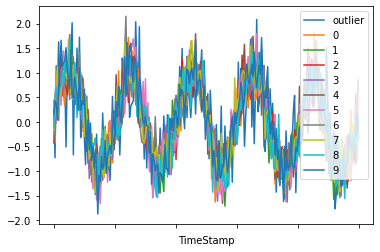

In [36]:
df.plot()

## Step Four: Write a mad() function 

This mad() function is the Python implementation of the Flux function outlined in this [blog](https://www.influxdata.com/blog/anomaly-detection-with-median-absolute-deviation/). 

In [56]:
def mad(data,tolerance):
    # k is a scale factor, to normalize our values. 
    k = 1.4826
    med_abs = data.mad(axis=1, skipna = False).mul(k, axis =0)
    med = data.median(axis=1,skipna = False)
    score = data.copy()
    score = score.sub(med, axis = 0).abs().div(med_abs, axis =0)
    binary = score.gt(tolerance)
    return binary


We pass in our dataframe to our mad() function. This implementation is the same as oulined here. 

## Step Five: Apply mad()

Use the mad() function to detect anomalous points in the data.

In [57]:
#Increasing the tolerance makes the mad() algorithm less sensitive and less susceptible to false positives.
#Decreaesing the tolerance makes the mad() aglorithm more sensitve and more susceptible to false positives. 
mad_df = mad(df,2.5)
mad_df.head(5)

,outlier,0,1,2,3,4,5,6,7,8,9
TimeStamp,,,,,,,,,,,
2020-01-01 00:00:00.000000000,False,False,False,False,False,False,False,False,False,False,False
2020-01-01 11:39:45.542168576,False,False,False,False,False,False,False,False,False,False,False
2020-01-01 23:19:31.084337408,False,False,False,False,False,False,False,False,False,False,False
2020-01-02 10:59:16.626505984,False,False,False,False,False,False,False,False,False,False,False
2020-01-02 22:39:02.168674816,True,False,False,False,False,False,False,False,False,False,False


mad() has detected severral anomalies (where the value of the row = True). To identify an anomalous series, find the total count of anomalies across each series. The series with the most anomalous can be defined as anomalous. 
Run the following code to find the total number of anomalies in the "outlier" series: 

In [58]:
mad_df['outlier'].value_counts()

False    238
True      12
Name: outlier, dtype: int64